In [2]:
from pymodbus.client.sync import ModbusTcpClient
from pymodbus.client.common import ModbusClientMixin
from pymodbus.constants import Defaults
from pyfirmata import Arduino

import os
import sys
import time
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pymodbus.client.sync'

In [8]:
import matplotlib.pyplot as plt

In [9]:
from simple_pid import PID

In [ ]:
Defaults.RetryOnEmpty = True

In [ ]:
#-----------------------------variable definition for receiving data
tur_rpm = 0.0      #Turbine rpm, address 1
max_rpm = 0.0      #Maximum rpm of all turbines
max_rpm0 = 0.0     #Maximum rpm for before time step
tur_vol = 0.0      #DC voltage from turbine, address 2
max_tur_vol = 0.0  #Maximum DC voltage from all turbines
inv_pwr = 0.0      #inverter power, address 24
dump_pwr = 0.0     #dumploaded power, address 5
total_pwr = 0.0     #total power = inverter power + dumploaded power
max_pwr = 0.0       #maximum total power
cont_in_vol = 0.0   #controller operating input voltage, address 3
windspeed = 0.0     #wind speed, address 0
fpin = 13           #실린더 후진 folding arduino pin
upin = 12           #실린더 전진 unfolding arduino pin
ycwpin = 11         #CW direction yawing arduino pin
yccwpin = 10        #CCW direction yawing arduino pin
motor_start = 9     #motor operating arduino pin

In [ ]:
#-------------------------------arduino initialize
port1='COM12' #control arduino port
baudrate=9600
board1=Arduino(port1)

In [ ]:
fpin=board1.get_pin('d:13:o') # folding pin setting
upin=board1.get_pin('d:12:o') # unfolding pin setting
ycwpin=board1.get_pin('d:11:o') # unfolding pin setting
yccwpin=board1.get_pin('d:10:o') # unfolding pin setting
motor_start=board1.get_pin('d:9:o') # unfolding pin setting

In [ ]:
#pin intitialize for arduino
fpin.write(0)
upin.write(0)
ycwpin.write(0)
yccwpin.write(0)
motor_start.write(0)

In [ ]:
#----------------------------------------Data receive from TCP
        while True:
            try:
# connection to controller
                client1 = ModbusTcpClient(host="192.168.8.7", port=502)
                print(client1.connect())
# read data from controller
                result = client1.read_input_registers(address=0, count=50, unit=i) #read data set

                tur_rpm = float(result.registers[1]) * 3.8  #read turbine rpm
                tur_vol = float(result.registers[2])   #read turbine DC voltate
                cont_in_vol = float(result.registers[3]) #read controller operating power voltate
                dump_pwr = float(result.registers[5]) #read dumploaded power
                inv_pwr = float(result.registers[24]) #read inverting power
                print("turbine ", i, "rpm= ", tur_rpm)

                if max_rpm<=tur_rpm:   # maximum rpm check
                    max_rpm = tur_rpm
                else:
                    max_rpm = max_rpm

                if max_tur_vol<=tur_vol:  # maximum turbine voltage check
                    max_tur_vol = tur_vol
                else:
                    max_tur_vol = max_tur_vol

                total_pwr = dump_pwr + inv_pwr  # maximum power check
                if max_pwr<=total_pwr:
                    max_pwr = total_pwr
                else:
                    max_pwr = max_pwr

                client1.close()

# slop calculation
                if max_rpm > 0:
                    slop_rpm = (max_rpm - max_rpm0)/max_rpm
                    max_rpm0 = max_rpm
                else:
                    slop_rpm = 0.0
            continue

In [10]:
class WaterBoiler:
    """
    Simple simulation of a water boiler which can heat up water
    and where the heat dissipates slowly over time
    """

    def __init__(self):
        self.water_temp = 20

    def update(self, boiler_power, dt):
        if boiler_power > 0:
            # Boiler can only produce heat, not cold
            self.water_temp += 1 * boiler_power * dt

        # Some heat dissipation
        self.water_temp -= 0.02 * dt
        return self.water_temp

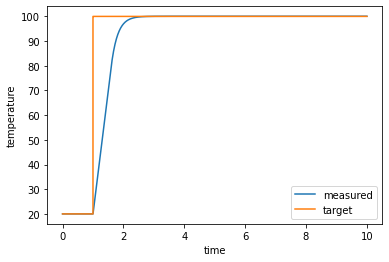

In [11]:
if __name__ == '__main__':
    boiler = WaterBoiler()
    water_temp = boiler.water_temp

    pid = PID(5, 0.01, 0.1, setpoint=water_temp)
    pid.output_limits = (0, 100)

    start_time = time.time()
    last_time = start_time

    # Keep track of values for plotting
    setpoint, y, x = [], [], []

    while time.time() - start_time < 10:
        current_time = time.time()
        dt = current_time - last_time

        power = pid(water_temp)
        water_temp = boiler.update(power, dt)

        x += [current_time - start_time]
        y += [water_temp]
        setpoint += [pid.setpoint]

        if current_time - start_time > 1:
            pid.setpoint = 100

        last_time = current_time

    plt.plot(x, y, label='measured')
    plt.plot(x, setpoint, label='target')
    plt.xlabel('time')
    plt.ylabel('temperature')
    plt.legend()
    if os.getenv('NO_DISPLAY'):
        # If run in CI the plot is saved to file instead of shown to the user
        plt.savefig(f"result-py{'.'.join([str(x) for x in sys.version_info[:2]])}.png")
    else:
        plt.show()
